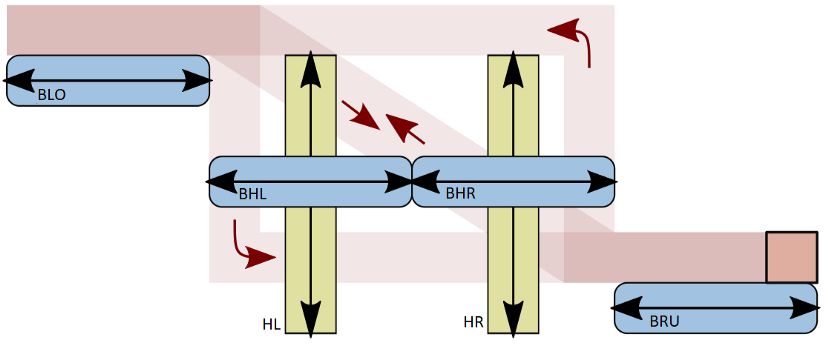

In [1]:
import os
import tqdm
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
df = pd.read_csv('HRSS_anomalous_optimized.csv')

print(df.shape)
df.head()

(19634, 20)


,Timestamp,Labels,I_w_BLO_Weg,O_w_BLO_power,O_w_BLO_voltage,I_w_BHL_Weg,O_w_BHL_power,O_w_BHL_voltage,I_w_BHR_Weg,O_w_BHR_power,O_w_BHR_voltage,I_w_BRU_Weg,O_w_BRU_power,O_w_BRU_voltage,I_w_HR_Weg,O_w_HR_power,O_w_HR_voltage,I_w_HL_Weg,O_w_HL_power,O_w_HL_voltage
0,0.000000,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
1,0.043999,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
2,0.099998,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
3,0.143997,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,12.0,1.0,-32.0,0.0,0.0,0.0,2560.0,24.0,0.0,3434.0,24.0
4,0.249001,0,7.0,0.0,0.0,-547.0,0.0,0.0,-874.0,7.0,1.0,22.0,18471.0,47.0,0.0,5764.0,26.0,0.0,5008.0,24.0


In [3]:
features = ['I_w_BLO_Weg', 'O_w_BLO_power', 'O_w_BLO_voltage', 'I_w_BHL_Weg', 
            'O_w_BHL_power', 'O_w_BHL_voltage', 'I_w_BHR_Weg', 'O_w_BHR_power', 
            'O_w_BHR_voltage', 'I_w_BRU_Weg', 'O_w_BRU_power', 'O_w_BRU_voltage', 
            'I_w_HR_Weg', 'O_w_HR_power', 'O_w_HR_voltage', 'I_w_HL_Weg', 
            'O_w_HL_power', 'O_w_HL_voltage']

In [4]:
df.Labels.value_counts()

0    15117
1     4517
Name: Labels, dtype: int64

Text(0, 0.5, 'Failure')

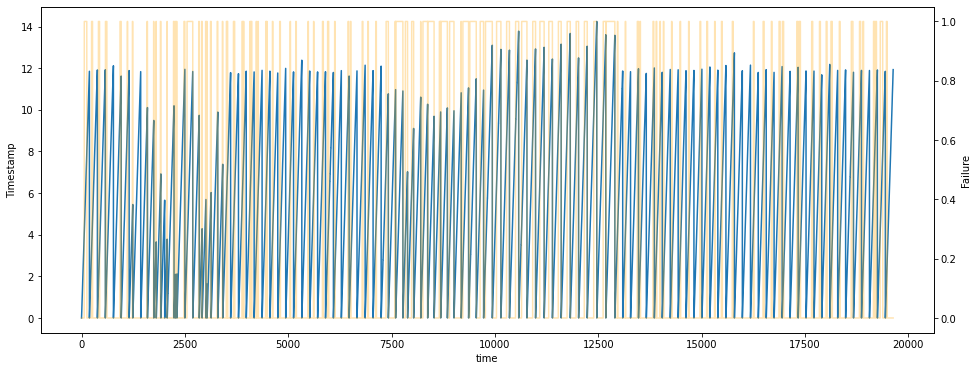

In [5]:
df.Timestamp.plot(figsize=(16,6))
plt.xlabel('time')
plt.ylabel('Timestamp')
plt.twinx()
plt.plot(df.Labels, alpha=0.3, c='orange')
plt.ylabel('Failure')

Text(0, 0.5, 'standard deviation')

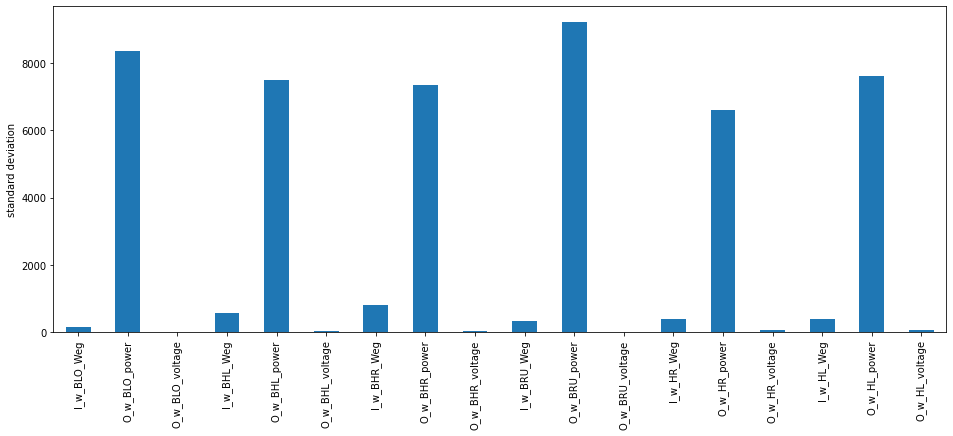

In [6]:
df.loc[:,features].std().plot.bar(figsize=(16,6))
plt.ylabel('standard deviation')

In [7]:
def gen_sequence(df, seq_length):
    
    seq_df = []
    
    for start, stop in zip(range(0, len(df)-seq_length), range(seq_length, len(df))):
        seq_df.append(df[start:stop, :])
        
    return np.asarray(seq_df)

In [8]:
# cycle

k = -1
cycle = []
for i,time in df.Timestamp.iteritems(): 
    if time==0.:
        k += 1
        cycle.append(k)
    else:
        cycle.append(k)
        
df['Timestamp'] = cycle

In [9]:
sequence_length = 8
test_size = 0.1

X_train, X_test = [], []
Y_train, Y_test = [], []

for k,group_df in df.groupby('Timestamp'):
    
    if int(len(group_df)*test_size) > sequence_length: 
    
        init = group_df[features].values[0] + 1e-3
        y = group_df.Labels.values
        x_train = group_df[features].values[:int(len(group_df)*(1-test_size))] / init
        x_test = group_df[features].values[int(len(group_df)*(1-test_size)):] / init

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        x_train = gen_sequence(x_train, sequence_length)
        x_test = gen_sequence(x_test, sequence_length)
        y_train = y[sequence_length:int(len(group_df)*(1-test_size))]
        y_test = y[int(len(group_df)*(1-test_size))+sequence_length:]

        Y_train.append(y_train); Y_test.append(y_test)
        X_train.append(x_train); X_test.append(x_test)
    
    else:
        continue
    
X_train, X_test = np.vstack(X_train), np.vstack(X_test)
print(X_train.shape, X_test.shape)
Y_train, Y_test = np.concatenate(Y_train), np.concatenate(Y_test)
print(Y_train.shape, Y_test.shape)

(16445, 8, 18) (1148, 8, 18)
(16445,) (1148,)


In [10]:
# test set

pd.value_counts(Y_test)

0    710
1    438
dtype: int64

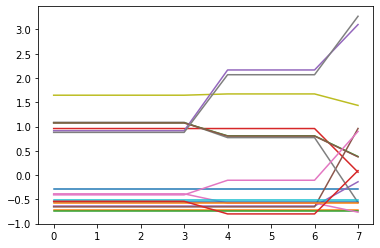

In [11]:
# an example plot

_id_ = 39

plt.plot(X_train[_id_])
np.set_printoptions(False)

In [12]:
# siamese network
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

left_input = []
right_input = []
targets = []
pairs = 3

for i in range(len(Y_train)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i:
            compare_to = random.randint(0,len(Y_train)-1)
        left_input.append(X_train[i])
        right_input.append(X_train[compare_to])
        if Y_train[i] == Y_train[compare_to]: 
            targets.append(1.)
        else:
            targets.append(0.)
            
left_input = np.asarray(left_input).reshape(-1, sequence_length, len(features))
right_input = np.asarray(right_input).reshape(-1, sequence_length, len(features))
targets = np.asarray(targets)
print(left_input.shape, right_input.shape, targets.shape)

(49335, 8, 18) (49335, 8, 18) (49335,)


In [13]:
# label distribution

pd.value_counts(targets)

1.0    32570
0.0    16765
dtype: int64

In [14]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def SiamesNet():
    
    set_seed(33)
    
    left_input = Input((sequence_length, len(features)))
    right_input = Input((sequence_length, len(features)))

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(128, activation='relu', return_sequences=True, 
             input_shape=(sequence_length, len(features))),
        LSTM(32, activation='relu')
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.2)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model

In [15]:
siamese_net = SiamesNet()
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])

siamese_net.fit([left_input, right_input], targets, batch_size=512, epochs=50, 
                validation_split=0.15, verbose=2)

Epoch 1/50


c:\Programs\Python\python-3.10.0-amd64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


82/82 - 12s - loss: 0.6424 - accuracy: 0.6541 - val_loss: 0.6301 - val_accuracy: 0.6754 - 12s/epoch - 150ms/step
Epoch 2/50
82/82 - 9s - loss: 0.6235 - accuracy: 0.6684 - val_loss: 0.6139 - val_accuracy: 0.6853 - 9s/epoch - 113ms/step
Epoch 3/50
82/82 - 9s - loss: 0.6100 - accuracy: 0.6860 - val_loss: 0.6085 - val_accuracy: 0.6979 - 9s/epoch - 115ms/step
Epoch 4/50
82/82 - 10s - loss: 0.5979 - accuracy: 0.6984 - val_loss: 0.6046 - val_accuracy: 0.7018 - 10s/epoch - 122ms/step
Epoch 5/50
82/82 - 9s - loss: 0.5887 - accuracy: 0.7053 - val_loss: 0.5898 - val_accuracy: 0.7148 - 9s/epoch - 115ms/step
Epoch 6/50
82/82 - 9s - loss: 0.5778 - accuracy: 0.7173 - val_loss: 0.5854 - val_accuracy: 0.7187 - 9s/epoch - 114ms/step
Epoch 7/50
82/82 - 10s - loss: 0.5669 - accuracy: 0.7241 - val_loss: 0.5800 - val_accuracy: 0.7168 - 10s/epoch - 117ms/step
Epoch 8/50
82/82 - 9s - loss: 0.5529 - accuracy: 0.7359 - val_loss: 0.5822 - val_accuracy: 0.7157 - 9s/epoch - 115ms/step
Epoch 9/50
82/82 - 10s - loss

In [16]:
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

real = []
pred = []
rep = 4

for j,i in enumerate(tqdm.tqdm(Y_test)):
    
    test = X_test[j]

    nofault = np.random.choice(np.where(Y_train == 0)[0], rep)
    nofault = X_train[nofault]
    nofault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in nofault])

    fault = np.random.choice(np.where(Y_train == 1)[0], rep)
    fault = X_train[fault]
    fault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in fault])
    
    pred.append('nofault' if nofault_sim > fault_sim else 'fault')
    real.append('nofault' if i == 0 else 'fault')

  0%|          | 0/1148 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/1148 [00:00<17:44,  1.08it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/1148 [00:01<11:54,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/1148 [00:01<10:05,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/1148 [00:02<09:57,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 5/1148 [00:02<10:04,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 6/1148 [00:03<10:03,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 7/1148 [00:03<09:54,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 8/1148 [00:04<09:58,  1.90it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 9/1148 [00:04<10:13,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 10/1148 [00:05<10:08,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 11/1148 [00:05<10:06,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 12/1148 [00:06<10:06,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 13/1148 [00:07<10:05,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 14/1148 [00:07<10:03,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 15/1148 [00:08<09:59,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 16/1148 [00:08<10:34,  1.78it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 17/1148 [00:09<11:06,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 18/1148 [00:09<10:42,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 19/1148 [00:10<10:38,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 20/1148 [00:11<10:20,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 21/1148 [00:11<10:05,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 22/1148 [00:12<09:59,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 23/1148 [00:12<09:49,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 24/1148 [00:13<09:45,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 25/1148 [00:13<09:44,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 26/1148 [00:14<09:43,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 27/1148 [00:14<09:41,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 28/1148 [00:15<09:35,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 29/1148 [00:15<09:32,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 30/1148 [00:16<09:33,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 31/1148 [00:16<09:32,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 32/1148 [00:17<09:36,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 33/1148 [00:17<09:32,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 34/1148 [00:18<09:32,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 35/1148 [00:18<09:31,  1.95it/s]

1/1 [==============================] - 0s 72ms/step


  3%|▎         | 36/1148 [00:19<09:47,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 37/1148 [00:19<09:51,  1.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 38/1148 [00:20<10:42,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 39/1148 [00:20<10:18,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 40/1148 [00:21<09:59,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 41/1148 [00:22<09:46,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 42/1148 [00:22<09:40,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 43/1148 [00:23<09:29,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 44/1148 [00:23<09:25,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 45/1148 [00:24<09:26,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 46/1148 [00:24<09:20,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 47/1148 [00:25<09:15,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 48/1148 [00:25<09:15,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 49/1148 [00:26<09:18,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 50/1148 [00:26<09:16,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 51/1148 [00:27<09:19,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 52/1148 [00:27<09:28,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 53/1148 [00:28<09:28,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 54/1148 [00:28<09:24,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 55/1148 [00:29<09:40,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 56/1148 [00:29<09:37,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 57/1148 [00:30<09:24,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 58/1148 [00:30<09:16,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 59/1148 [00:31<09:12,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 60/1148 [00:31<09:11,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 61/1148 [00:32<09:16,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 62/1148 [00:32<09:20,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 63/1148 [00:33<09:16,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 64/1148 [00:33<09:14,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 65/1148 [00:34<09:22,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 66/1148 [00:34<09:16,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 67/1148 [00:35<09:16,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 68/1148 [00:35<09:15,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 69/1148 [00:36<09:16,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 70/1148 [00:36<09:15,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 71/1148 [00:37<09:15,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 72/1148 [00:37<09:15,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 73/1148 [00:38<09:32,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 74/1148 [00:39<09:38,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 75/1148 [00:39<09:32,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 76/1148 [00:40<09:31,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 77/1148 [00:40<09:29,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 78/1148 [00:41<09:21,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 79/1148 [00:41<09:15,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 80/1148 [00:42<09:09,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 81/1148 [00:42<09:16,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 82/1148 [00:43<09:14,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 83/1148 [00:43<09:15,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 84/1148 [00:44<09:12,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 85/1148 [00:44<09:10,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 86/1148 [00:45<09:07,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 87/1148 [00:45<09:12,  1.92it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 88/1148 [00:46<09:10,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 89/1148 [00:46<09:12,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 90/1148 [00:47<09:15,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 91/1148 [00:47<09:31,  1.85it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 92/1148 [00:48<09:26,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 93/1148 [00:48<09:19,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 94/1148 [00:49<09:17,  1.89it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 95/1148 [00:50<09:15,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 96/1148 [00:50<09:13,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 97/1148 [00:51<09:18,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 98/1148 [00:51<09:48,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 99/1148 [00:52<09:40,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 100/1148 [00:52<09:32,  1.83it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 101/1148 [00:53<09:27,  1.85it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 102/1148 [00:53<09:12,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 103/1148 [00:54<09:13,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 104/1148 [00:54<09:06,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 105/1148 [00:55<09:00,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 106/1148 [00:55<09:03,  1.92it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 107/1148 [00:56<09:24,  1.84it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 108/1148 [00:57<09:20,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 109/1148 [00:57<09:13,  1.88it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 110/1148 [00:58<09:16,  1.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 111/1148 [00:58<09:24,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 112/1148 [00:59<09:33,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 113/1148 [00:59<09:48,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 114/1148 [01:00<09:32,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 115/1148 [01:00<09:24,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 116/1148 [01:01<09:23,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 117/1148 [01:01<09:07,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 118/1148 [01:02<08:56,  1.92it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 119/1148 [01:02<08:49,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 120/1148 [01:03<08:52,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 121/1148 [01:03<08:48,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 122/1148 [01:04<09:21,  1.83it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 123/1148 [01:05<09:26,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 124/1148 [01:05<09:41,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 125/1148 [01:06<09:35,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 126/1148 [01:06<09:22,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 127/1148 [01:07<09:07,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 128/1148 [01:07<09:07,  1.86it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 129/1148 [01:08<09:00,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 130/1148 [01:08<08:50,  1.92it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 131/1148 [01:09<08:58,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 132/1148 [01:09<08:57,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 133/1148 [01:10<08:45,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 134/1148 [01:10<08:42,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 135/1148 [01:11<08:43,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 136/1148 [01:12<08:50,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 137/1148 [01:12<09:14,  1.82it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 138/1148 [01:13<09:06,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 139/1148 [01:13<09:01,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 140/1148 [01:14<08:52,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 141/1148 [01:14<08:58,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 142/1148 [01:15<09:02,  1.85it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 143/1148 [01:16<10:03,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 144/1148 [01:16<09:48,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 145/1148 [01:17<09:31,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 146/1148 [01:17<09:23,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 147/1148 [01:18<09:17,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 148/1148 [01:18<09:05,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 149/1148 [01:19<08:52,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 150/1148 [01:19<08:50,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 151/1148 [01:20<09:06,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 152/1148 [01:20<09:09,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 153/1148 [01:21<09:11,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 154/1148 [01:21<09:04,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 155/1148 [01:22<09:07,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 156/1148 [01:23<09:02,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 157/1148 [01:23<09:00,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 158/1148 [01:24<09:06,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 159/1148 [01:24<08:56,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 160/1148 [01:25<08:48,  1.87it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 161/1148 [01:25<08:48,  1.87it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 162/1148 [01:26<08:43,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 163/1148 [01:26<08:40,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 164/1148 [01:27<08:37,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 165/1148 [01:27<09:02,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 166/1148 [01:28<08:52,  1.84it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 167/1148 [01:28<08:44,  1.87it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 168/1148 [01:29<08:41,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 169/1148 [01:30<08:33,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 170/1148 [01:30<08:24,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 171/1148 [01:31<08:23,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 172/1148 [01:31<08:24,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 173/1148 [01:32<08:12,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 174/1148 [01:32<07:51,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 175/1148 [01:32<07:43,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 176/1148 [01:33<07:29,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 177/1148 [01:33<07:20,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 178/1148 [01:34<07:13,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 179/1148 [01:34<07:22,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 180/1148 [01:35<07:16,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 181/1148 [01:35<07:13,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 182/1148 [01:35<07:07,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 183/1148 [01:36<07:07,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 184/1148 [01:36<07:04,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 185/1148 [01:37<07:03,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 186/1148 [01:37<07:00,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 187/1148 [01:38<07:00,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 188/1148 [01:38<06:59,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 189/1148 [01:39<07:13,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 190/1148 [01:39<07:32,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 191/1148 [01:40<07:49,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 192/1148 [01:40<08:02,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 193/1148 [01:41<08:27,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 194/1148 [01:41<08:30,  1.87it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 195/1148 [01:42<08:25,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 196/1148 [01:42<08:22,  1.89it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 197/1148 [01:43<08:27,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 198/1148 [01:44<08:45,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 199/1148 [01:44<08:49,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 200/1148 [01:44<07:57,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 201/1148 [01:45<07:21,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 202/1148 [01:45<07:00,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 203/1148 [01:46<06:32,  2.41it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 204/1148 [01:46<06:11,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 205/1148 [01:46<06:06,  2.57it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 206/1148 [01:47<06:04,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 207/1148 [01:47<05:54,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 208/1148 [01:47<05:56,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 209/1148 [01:48<06:04,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 210/1148 [01:48<05:56,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 211/1148 [01:49<05:54,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 212/1148 [01:49<05:47,  2.69it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 213/1148 [01:50<06:53,  2.26it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 214/1148 [01:50<07:33,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 215/1148 [01:51<07:28,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 216/1148 [01:51<07:03,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 217/1148 [01:51<06:53,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 218/1148 [01:52<06:27,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 219/1148 [01:52<06:17,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 220/1148 [01:53<06:06,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 221/1148 [01:53<05:54,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 222/1148 [01:53<06:05,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 223/1148 [01:54<06:04,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 224/1148 [01:54<06:07,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 225/1148 [01:55<06:40,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 226/1148 [01:55<07:00,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 227/1148 [01:56<07:14,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 228/1148 [01:56<07:52,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 229/1148 [01:57<08:10,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 230/1148 [01:57<08:48,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 231/1148 [01:58<08:38,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 232/1148 [01:59<08:29,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 233/1148 [01:59<08:10,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 234/1148 [02:00<08:28,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 235/1148 [02:00<07:57,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 236/1148 [02:01<07:53,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 237/1148 [02:01<07:45,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 238/1148 [02:02<07:28,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 239/1148 [02:02<06:56,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 240/1148 [02:02<06:34,  2.30it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 241/1148 [02:03<06:31,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 242/1148 [02:03<06:22,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 243/1148 [02:04<06:11,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 244/1148 [02:04<06:06,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 245/1148 [02:04<05:50,  2.57it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 246/1148 [02:05<06:02,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 247/1148 [02:05<05:51,  2.56it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 248/1148 [02:06<06:25,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 249/1148 [02:06<06:18,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 250/1148 [02:06<06:16,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 251/1148 [02:07<06:02,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 252/1148 [02:07<06:04,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 253/1148 [02:08<05:46,  2.59it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 254/1148 [02:08<05:33,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 255/1148 [02:08<05:25,  2.74it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 256/1148 [02:09<05:32,  2.68it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 257/1148 [02:09<06:01,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 258/1148 [02:09<06:03,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 259/1148 [02:10<06:06,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 260/1148 [02:10<05:57,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 261/1148 [02:11<05:45,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 262/1148 [02:11<05:33,  2.66it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 263/1148 [02:11<05:22,  2.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 264/1148 [02:12<05:18,  2.78it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 265/1148 [02:12<05:15,  2.80it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 266/1148 [02:12<05:13,  2.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 267/1148 [02:13<05:08,  2.85it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 268/1148 [02:13<05:04,  2.89it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 269/1148 [02:13<05:06,  2.87it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 270/1148 [02:14<05:10,  2.83it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 271/1148 [02:14<05:09,  2.84it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 272/1148 [02:14<05:07,  2.85it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 273/1148 [02:15<05:08,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 274/1148 [02:15<05:17,  2.75it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 275/1148 [02:16<05:13,  2.79it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 276/1148 [02:16<05:06,  2.84it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 277/1148 [02:16<04:58,  2.91it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 278/1148 [02:17<04:52,  2.97it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 279/1148 [02:17<04:52,  2.97it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 280/1148 [02:17<04:48,  3.01it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 281/1148 [02:18<04:47,  3.02it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 282/1148 [02:18<04:46,  3.02it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 283/1148 [02:18<04:45,  3.03it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 284/1148 [02:19<04:45,  3.03it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 285/1148 [02:19<04:45,  3.03it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 286/1148 [02:19<04:45,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 287/1148 [02:20<04:45,  3.01it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 288/1148 [02:20<04:45,  3.01it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 289/1148 [02:20<04:54,  2.92it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 290/1148 [02:21<04:54,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 291/1148 [02:21<04:55,  2.90it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 292/1148 [02:21<05:01,  2.84it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 293/1148 [02:22<04:58,  2.86it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 294/1148 [02:22<04:56,  2.88it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 295/1148 [02:22<04:52,  2.92it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 296/1148 [02:23<04:48,  2.95it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 297/1148 [02:23<04:45,  2.98it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 298/1148 [02:23<04:42,  3.01it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 299/1148 [02:24<04:42,  3.00it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 300/1148 [02:24<04:41,  3.01it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 301/1148 [02:24<04:46,  2.95it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 302/1148 [02:25<04:44,  2.98it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 303/1148 [02:25<04:43,  2.98it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 304/1148 [02:25<04:42,  2.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 305/1148 [02:26<04:44,  2.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 306/1148 [02:26<04:55,  2.85it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 307/1148 [02:26<04:56,  2.83it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 308/1148 [02:27<04:59,  2.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 309/1148 [02:27<04:59,  2.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 310/1148 [02:27<04:54,  2.85it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 311/1148 [02:28<05:02,  2.77it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 312/1148 [02:28<04:56,  2.82it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 313/1148 [02:28<04:52,  2.86it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 314/1148 [02:29<04:47,  2.90it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 315/1148 [02:29<04:44,  2.93it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 316/1148 [02:29<04:40,  2.96it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 317/1148 [02:30<04:37,  2.99it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 318/1148 [02:30<04:46,  2.90it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 319/1148 [02:31<05:00,  2.76it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 320/1148 [02:31<05:02,  2.74it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 321/1148 [02:31<04:55,  2.80it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 322/1148 [02:32<04:47,  2.87it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 323/1148 [02:32<04:41,  2.93it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 324/1148 [02:32<04:37,  2.97it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 325/1148 [02:33<04:34,  3.00it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 326/1148 [02:33<04:33,  3.01it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 327/1148 [02:33<04:31,  3.03it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 328/1148 [02:34<04:30,  3.03it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 329/1148 [02:34<04:30,  3.02it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 330/1148 [02:34<04:29,  3.04it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 331/1148 [02:35<04:29,  3.04it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 332/1148 [02:35<04:29,  3.03it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 333/1148 [02:35<04:27,  3.04it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 334/1148 [02:36<04:26,  3.05it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 335/1148 [02:36<04:29,  3.02it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 336/1148 [02:36<04:27,  3.04it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 337/1148 [02:37<04:25,  3.05it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 338/1148 [02:37<04:25,  3.05it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 339/1148 [02:37<04:25,  3.05it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 340/1148 [02:38<04:23,  3.06it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 341/1148 [02:38<04:23,  3.06it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 342/1148 [02:38<04:23,  3.06it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 343/1148 [02:39<04:20,  3.08it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 344/1148 [02:39<04:23,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 345/1148 [02:39<04:58,  2.69it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 346/1148 [02:40<05:35,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 347/1148 [02:40<05:58,  2.24it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 348/1148 [02:41<06:06,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 349/1148 [02:41<05:52,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 350/1148 [02:42<05:39,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 351/1148 [02:42<05:43,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 352/1148 [02:43<06:01,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 353/1148 [02:43<05:41,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 354/1148 [02:43<05:24,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 355/1148 [02:44<05:12,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 356/1148 [02:44<05:11,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 357/1148 [02:44<05:08,  2.57it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 358/1148 [02:45<05:01,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 359/1148 [02:45<04:54,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 360/1148 [02:46<04:50,  2.72it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 361/1148 [02:46<04:41,  2.80it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 362/1148 [02:46<04:53,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 363/1148 [02:47<04:53,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 364/1148 [02:47<04:55,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 365/1148 [02:47<04:53,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 366/1148 [02:48<04:52,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 367/1148 [02:48<04:56,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 368/1148 [02:49<04:51,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 369/1148 [02:49<04:43,  2.75it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 370/1148 [02:49<04:42,  2.76it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 371/1148 [02:50<04:37,  2.80it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 372/1148 [02:50<04:38,  2.79it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 373/1148 [02:50<04:38,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 374/1148 [02:51<04:36,  2.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 375/1148 [02:51<04:32,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 376/1148 [02:51<04:36,  2.79it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 377/1148 [02:52<04:52,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 378/1148 [02:52<04:50,  2.65it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 379/1148 [02:52<04:41,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 380/1148 [02:53<04:34,  2.80it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 381/1148 [02:53<04:34,  2.79it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 382/1148 [02:54<04:37,  2.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 383/1148 [02:54<04:39,  2.73it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 384/1148 [02:54<04:40,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 385/1148 [02:55<04:43,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 386/1148 [02:55<04:40,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 387/1148 [02:55<04:39,  2.72it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 388/1148 [02:56<04:32,  2.79it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 389/1148 [02:56<04:30,  2.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 390/1148 [02:56<04:32,  2.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 391/1148 [02:57<04:44,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 392/1148 [02:57<04:47,  2.63it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 393/1148 [02:58<04:46,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 394/1148 [02:58<04:50,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 395/1148 [02:58<04:52,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 396/1148 [02:59<04:54,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 397/1148 [02:59<04:57,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 398/1148 [03:00<04:59,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 399/1148 [03:00<04:56,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 400/1148 [03:00<05:00,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 401/1148 [03:01<04:58,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 402/1148 [03:01<04:59,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 403/1148 [03:02<04:58,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 404/1148 [03:02<05:00,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 405/1148 [03:02<05:00,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 406/1148 [03:03<05:04,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 407/1148 [03:03<05:14,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 408/1148 [03:04<05:35,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 409/1148 [03:05<06:16,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 410/1148 [03:05<06:37,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 411/1148 [03:06<06:09,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 412/1148 [03:06<05:49,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 413/1148 [03:06<05:39,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 414/1148 [03:07<05:26,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 415/1148 [03:07<05:20,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 416/1148 [03:08<05:11,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 417/1148 [03:08<05:04,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 418/1148 [03:08<05:03,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 419/1148 [03:09<05:02,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 420/1148 [03:09<05:01,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 421/1148 [03:10<04:58,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 422/1148 [03:10<05:02,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 423/1148 [03:10<04:56,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 424/1148 [03:11<05:08,  2.35it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 425/1148 [03:11<05:10,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 426/1148 [03:12<05:12,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 427/1148 [03:12<05:05,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 428/1148 [03:13<05:03,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 429/1148 [03:13<05:05,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 430/1148 [03:13<05:00,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 431/1148 [03:14<04:57,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 432/1148 [03:14<05:00,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 433/1148 [03:15<04:59,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 434/1148 [03:15<05:01,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 435/1148 [03:16<05:00,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 436/1148 [03:16<04:54,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 437/1148 [03:16<05:02,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 438/1148 [03:17<05:07,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 439/1148 [03:17<05:40,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 440/1148 [03:18<05:56,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 441/1148 [03:18<05:37,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 442/1148 [03:19<05:25,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 443/1148 [03:19<05:09,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 444/1148 [03:20<05:00,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 445/1148 [03:20<04:52,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 446/1148 [03:20<04:44,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 447/1148 [03:21<04:40,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 448/1148 [03:21<04:40,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 449/1148 [03:22<04:38,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 450/1148 [03:22<04:37,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 451/1148 [03:22<04:37,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 452/1148 [03:23<04:36,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 453/1148 [03:23<04:35,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 454/1148 [03:24<04:32,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 455/1148 [03:24<05:05,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 456/1148 [03:24<04:48,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 457/1148 [03:25<04:40,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 458/1148 [03:25<04:38,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 459/1148 [03:26<04:36,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 460/1148 [03:26<04:33,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 461/1148 [03:26<04:30,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 462/1148 [03:27<04:28,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 463/1148 [03:27<04:31,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 464/1148 [03:28<04:44,  2.41it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 465/1148 [03:28<05:09,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 466/1148 [03:29<05:21,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 467/1148 [03:29<05:06,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 468/1148 [03:30<04:57,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 469/1148 [03:30<04:46,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 470/1148 [03:30<04:46,  2.36it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 471/1148 [03:31<04:51,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 472/1148 [03:31<05:24,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 473/1148 [03:32<05:17,  2.13it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 474/1148 [03:32<05:15,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 475/1148 [03:33<05:16,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 476/1148 [03:33<05:24,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 477/1148 [03:34<05:17,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 478/1148 [03:34<05:10,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 479/1148 [03:35<04:59,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 480/1148 [03:35<05:03,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 481/1148 [03:36<05:07,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 482/1148 [03:36<04:58,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 483/1148 [03:36<04:41,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 484/1148 [03:37<04:25,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 485/1148 [03:37<04:10,  2.64it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 486/1148 [03:37<04:01,  2.74it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 487/1148 [03:38<03:56,  2.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 488/1148 [03:38<03:54,  2.82it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 489/1148 [03:38<03:50,  2.86it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 490/1148 [03:39<03:49,  2.86it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 491/1148 [03:39<03:48,  2.88it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 492/1148 [03:39<03:43,  2.93it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 493/1148 [03:40<03:41,  2.96it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 494/1148 [03:40<03:38,  2.99it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 495/1148 [03:40<03:43,  2.92it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 496/1148 [03:41<03:42,  2.93it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 497/1148 [03:41<03:39,  2.97it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 498/1148 [03:41<03:48,  2.84it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 499/1148 [03:42<03:44,  2.89it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 500/1148 [03:42<03:41,  2.93it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 501/1148 [03:42<03:39,  2.95it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 502/1148 [03:43<03:40,  2.94it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 503/1148 [03:43<03:49,  2.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 504/1148 [03:44<03:58,  2.70it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 505/1148 [03:44<04:03,  2.64it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 506/1148 [03:44<03:54,  2.73it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 507/1148 [03:45<03:47,  2.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 508/1148 [03:45<03:42,  2.87it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 509/1148 [03:45<03:38,  2.93it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 510/1148 [03:46<03:35,  2.96it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 511/1148 [03:46<03:32,  2.99it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 512/1148 [03:46<03:29,  3.03it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 513/1148 [03:47<03:30,  3.01it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 514/1148 [03:47<03:29,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 515/1148 [03:47<03:29,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 516/1148 [03:48<03:32,  2.98it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 517/1148 [03:48<03:30,  2.99it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 518/1148 [03:48<03:29,  3.01it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 519/1148 [03:49<03:28,  3.02it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 520/1148 [03:49<03:28,  3.01it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 521/1148 [03:49<03:29,  3.00it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 522/1148 [03:50<03:30,  2.98it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 523/1148 [03:50<03:28,  3.00it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 524/1148 [03:50<03:33,  2.92it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 525/1148 [03:51<03:33,  2.92it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 526/1148 [03:51<03:31,  2.95it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 527/1148 [03:51<03:28,  2.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 528/1148 [03:52<03:30,  2.95it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 529/1148 [03:52<03:43,  2.77it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 530/1148 [03:52<03:40,  2.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 531/1148 [03:53<03:37,  2.83it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 532/1148 [03:53<03:37,  2.83it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 533/1148 [03:53<03:34,  2.87it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 534/1148 [03:54<03:34,  2.86it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 535/1148 [03:54<03:35,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 536/1148 [03:55<03:40,  2.78it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 537/1148 [03:55<03:39,  2.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 538/1148 [03:55<03:36,  2.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 539/1148 [03:56<03:41,  2.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 540/1148 [03:56<03:46,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 541/1148 [03:56<03:51,  2.62it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 542/1148 [03:57<03:54,  2.59it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 543/1148 [03:57<03:45,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 544/1148 [03:58<03:46,  2.66it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 545/1148 [03:58<03:38,  2.76it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 546/1148 [03:58<03:32,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 547/1148 [03:59<03:35,  2.79it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 548/1148 [03:59<03:36,  2.77it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 549/1148 [03:59<03:38,  2.74it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 550/1148 [04:00<03:43,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 551/1148 [04:00<03:47,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 552/1148 [04:01<03:49,  2.60it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 553/1148 [04:01<03:41,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 554/1148 [04:01<03:43,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 555/1148 [04:02<03:38,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 556/1148 [04:02<03:34,  2.77it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 557/1148 [04:02<03:30,  2.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 558/1148 [04:03<03:31,  2.79it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 559/1148 [04:03<04:02,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 560/1148 [04:04<03:58,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 561/1148 [04:04<03:47,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 562/1148 [04:04<03:44,  2.61it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 563/1148 [04:05<03:37,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 564/1148 [04:05<03:34,  2.73it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 565/1148 [04:05<03:31,  2.76it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 566/1148 [04:06<03:25,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 567/1148 [04:06<03:22,  2.87it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 568/1148 [04:06<03:20,  2.89it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 569/1148 [04:07<03:18,  2.91it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 570/1148 [04:07<03:20,  2.89it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 571/1148 [04:07<03:17,  2.93it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 572/1148 [04:08<03:14,  2.96it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 573/1148 [04:08<03:15,  2.94it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 574/1148 [04:08<03:12,  2.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 575/1148 [04:09<03:16,  2.92it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 576/1148 [04:09<03:15,  2.93it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 577/1148 [04:09<03:19,  2.86it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 578/1148 [04:10<03:21,  2.82it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 579/1148 [04:10<03:24,  2.78it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 580/1148 [04:11<03:24,  2.78it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 581/1148 [04:11<03:31,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 582/1148 [04:11<03:53,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 583/1148 [04:12<03:50,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 584/1148 [04:12<03:49,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 585/1148 [04:13<03:50,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 586/1148 [04:13<03:48,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 587/1148 [04:13<03:44,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 588/1148 [04:14<03:42,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 589/1148 [04:14<03:39,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 590/1148 [04:15<03:36,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 591/1148 [04:15<03:34,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 592/1148 [04:15<03:31,  2.62it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 593/1148 [04:16<03:32,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 594/1148 [04:16<03:30,  2.63it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 595/1148 [04:16<03:30,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 596/1148 [04:17<03:42,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 597/1148 [04:17<03:59,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 598/1148 [04:18<03:58,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 599/1148 [04:18<04:02,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 600/1148 [04:19<03:55,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 601/1148 [04:19<03:45,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 602/1148 [04:20<03:49,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 603/1148 [04:20<03:43,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 604/1148 [04:20<03:42,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 605/1148 [04:21<03:37,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 606/1148 [04:21<03:48,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 607/1148 [04:22<03:52,  2.33it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 608/1148 [04:22<03:50,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 609/1148 [04:22<03:48,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 610/1148 [04:23<03:54,  2.30it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 611/1148 [04:23<03:50,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 612/1148 [04:24<03:49,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 613/1148 [04:24<03:54,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 614/1148 [04:25<03:54,  2.28it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 615/1148 [04:25<03:55,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 616/1148 [04:26<04:11,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 617/1148 [04:26<03:58,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 618/1148 [04:26<03:45,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 619/1148 [04:27<03:35,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 620/1148 [04:27<03:39,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 621/1148 [04:28<03:34,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 622/1148 [04:28<03:28,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 623/1148 [04:28<03:25,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 624/1148 [04:29<03:22,  2.59it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 625/1148 [04:29<03:27,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 626/1148 [04:30<03:30,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 627/1148 [04:30<03:34,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 628/1148 [04:30<03:36,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 629/1148 [04:31<03:30,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 630/1148 [04:31<03:25,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 631/1148 [04:32<03:21,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 632/1148 [04:32<03:19,  2.59it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 633/1148 [04:32<03:16,  2.62it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 634/1148 [04:33<03:21,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 635/1148 [04:33<03:16,  2.61it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 636/1148 [04:33<03:10,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 637/1148 [04:34<03:14,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 638/1148 [04:34<03:12,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 639/1148 [04:35<03:08,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 640/1148 [04:35<03:10,  2.66it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 641/1148 [04:35<03:07,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 642/1148 [04:36<03:04,  2.75it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 643/1148 [04:36<03:07,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 644/1148 [04:36<03:06,  2.71it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 645/1148 [04:37<03:03,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 646/1148 [04:37<03:03,  2.73it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 647/1148 [04:38<03:07,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 648/1148 [04:38<03:04,  2.71it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 649/1148 [04:38<03:01,  2.75it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 650/1148 [04:39<03:06,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 651/1148 [04:39<03:04,  2.70it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 652/1148 [04:39<03:00,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 653/1148 [04:40<03:06,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 654/1148 [04:40<03:02,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 655/1148 [04:40<02:58,  2.76it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 656/1148 [04:41<03:04,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 657/1148 [04:41<03:00,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 658/1148 [04:42<02:58,  2.75it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 659/1148 [04:42<03:04,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 660/1148 [04:42<03:01,  2.68it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 661/1148 [04:43<02:59,  2.71it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 662/1148 [04:43<03:29,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 663/1148 [04:44<03:21,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 664/1148 [04:44<03:20,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 665/1148 [04:45<03:26,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 666/1148 [04:45<03:20,  2.41it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 667/1148 [04:45<03:10,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 668/1148 [04:46<03:10,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 669/1148 [04:46<03:04,  2.60it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 670/1148 [04:46<02:58,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 671/1148 [04:47<02:59,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 672/1148 [04:47<02:57,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 673/1148 [04:48<03:00,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 674/1148 [04:48<03:24,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 675/1148 [04:49<03:29,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 676/1148 [04:49<03:31,  2.23it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 677/1148 [04:50<03:43,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 678/1148 [04:50<03:38,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 679/1148 [04:50<03:31,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 680/1148 [04:51<03:30,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 681/1148 [04:51<03:18,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 682/1148 [04:52<03:10,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 683/1148 [04:52<03:19,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 684/1148 [04:53<03:28,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 685/1148 [04:53<03:20,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 686/1148 [04:53<03:13,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 687/1148 [04:54<03:08,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 688/1148 [04:54<03:02,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 689/1148 [04:55<03:06,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 690/1148 [04:55<03:02,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 691/1148 [04:55<02:59,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 692/1148 [04:56<02:58,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 693/1148 [04:56<02:58,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 694/1148 [04:56<02:55,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 695/1148 [04:57<02:53,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 696/1148 [04:57<02:56,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 697/1148 [04:58<03:03,  2.45it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 698/1148 [04:58<03:17,  2.28it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 699/1148 [04:59<03:21,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 700/1148 [04:59<03:25,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 701/1148 [05:00<03:23,  2.19it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 702/1148 [05:00<03:31,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 703/1148 [05:01<03:40,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 704/1148 [05:01<03:42,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 705/1148 [05:02<03:56,  1.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 706/1148 [05:02<03:44,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 707/1148 [05:03<03:43,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 708/1148 [05:03<03:40,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 709/1148 [05:04<03:25,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 710/1148 [05:04<03:26,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 711/1148 [05:04<03:16,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 712/1148 [05:05<03:06,  2.34it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 713/1148 [05:05<02:55,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 714/1148 [05:06<02:51,  2.53it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 715/1148 [05:06<02:45,  2.62it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 716/1148 [05:06<02:41,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 717/1148 [05:07<02:38,  2.71it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 718/1148 [05:07<02:36,  2.75it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 719/1148 [05:07<02:34,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 720/1148 [05:08<02:34,  2.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 721/1148 [05:08<02:40,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 722/1148 [05:09<02:42,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 723/1148 [05:09<02:41,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 724/1148 [05:09<02:40,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 725/1148 [05:10<02:37,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 726/1148 [05:10<02:32,  2.76it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 727/1148 [05:10<02:34,  2.73it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 728/1148 [05:11<02:31,  2.77it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 729/1148 [05:11<02:29,  2.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 730/1148 [05:11<02:27,  2.83it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 731/1148 [05:12<02:28,  2.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 732/1148 [05:12<02:29,  2.79it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 733/1148 [05:12<02:29,  2.78it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 734/1148 [05:13<02:30,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 735/1148 [05:13<02:30,  2.75it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 736/1148 [05:14<02:30,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 737/1148 [05:14<02:31,  2.71it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 738/1148 [05:14<02:31,  2.71it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 739/1148 [05:15<02:30,  2.73it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 740/1148 [05:15<02:30,  2.71it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 741/1148 [05:15<02:31,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 742/1148 [05:16<02:34,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 743/1148 [05:16<02:36,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 744/1148 [05:17<02:37,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 745/1148 [05:17<02:37,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 746/1148 [05:17<02:42,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 747/1148 [05:18<02:42,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 748/1148 [05:18<02:42,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 749/1148 [05:19<02:47,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 750/1148 [05:19<02:49,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 751/1148 [05:20<02:46,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 752/1148 [05:20<02:45,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 753/1148 [05:20<02:49,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 754/1148 [05:21<02:47,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 755/1148 [05:21<02:48,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 756/1148 [05:22<02:49,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 757/1148 [05:22<02:43,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 758/1148 [05:23<02:39,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 759/1148 [05:23<02:38,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 760/1148 [05:23<02:37,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 761/1148 [05:24<02:59,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 762/1148 [05:24<03:00,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 763/1148 [05:25<02:53,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 764/1148 [05:25<02:46,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 765/1148 [05:26<02:40,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 766/1148 [05:26<02:58,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 767/1148 [05:27<02:47,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 768/1148 [05:27<02:41,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 769/1148 [05:27<02:37,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 770/1148 [05:28<02:43,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 771/1148 [05:28<02:42,  2.32it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 772/1148 [05:29<02:49,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 773/1148 [05:29<02:46,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 774/1148 [05:30<02:46,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 775/1148 [05:30<02:43,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 776/1148 [05:30<02:46,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 777/1148 [05:31<02:44,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 778/1148 [05:31<02:41,  2.29it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 779/1148 [05:32<02:38,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 780/1148 [05:32<02:36,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 781/1148 [05:33<02:35,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 782/1148 [05:33<02:35,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 783/1148 [05:33<02:35,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 784/1148 [05:34<02:35,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 785/1148 [05:34<02:39,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 786/1148 [05:35<02:40,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 787/1148 [05:35<02:47,  2.15it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 788/1148 [05:36<02:54,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 789/1148 [05:36<02:53,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 790/1148 [05:37<02:51,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 791/1148 [05:37<02:47,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 792/1148 [05:38<02:43,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 793/1148 [05:38<02:39,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 794/1148 [05:39<02:36,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 795/1148 [05:39<02:41,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 796/1148 [05:39<02:41,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 797/1148 [05:40<02:37,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 798/1148 [05:40<02:34,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 799/1148 [05:41<02:32,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 800/1148 [05:41<02:30,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 801/1148 [05:42<02:32,  2.27it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 802/1148 [05:42<02:40,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 803/1148 [05:43<02:43,  2.11it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 804/1148 [05:43<02:42,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 805/1148 [05:44<02:35,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 806/1148 [05:44<02:28,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 807/1148 [05:44<02:29,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 808/1148 [05:45<02:23,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 809/1148 [05:45<02:18,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 810/1148 [05:46<02:14,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 811/1148 [05:46<02:11,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 812/1148 [05:46<02:09,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 813/1148 [05:47<02:14,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 814/1148 [05:47<02:12,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 815/1148 [05:48<02:15,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 816/1148 [05:48<02:12,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 817/1148 [05:48<02:09,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 818/1148 [05:49<02:07,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 819/1148 [05:49<02:06,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 820/1148 [05:49<02:11,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 821/1148 [05:50<02:08,  2.55it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 822/1148 [05:50<02:06,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 823/1148 [05:51<02:04,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 824/1148 [05:51<02:02,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 825/1148 [05:51<02:00,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 826/1148 [05:52<02:00,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 827/1148 [05:52<02:04,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 828/1148 [05:53<02:11,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 829/1148 [05:53<02:11,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 830/1148 [05:53<02:07,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 831/1148 [05:54<02:04,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 832/1148 [05:54<02:08,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 833/1148 [05:55<02:04,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 834/1148 [05:55<02:08,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 835/1148 [05:55<02:13,  2.35it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 836/1148 [05:56<02:15,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 837/1148 [05:56<02:16,  2.28it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 838/1148 [05:57<02:17,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 839/1148 [05:57<02:24,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 840/1148 [05:58<02:23,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 841/1148 [05:58<02:26,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 842/1148 [05:59<02:24,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 843/1148 [05:59<02:23,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 844/1148 [06:00<02:22,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 845/1148 [06:00<02:21,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 846/1148 [06:01<02:27,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 847/1148 [06:01<02:24,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 848/1148 [06:02<02:26,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 849/1148 [06:02<02:23,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 850/1148 [06:03<02:20,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 851/1148 [06:03<02:18,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 852/1148 [06:03<02:16,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 853/1148 [06:04<02:15,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 854/1148 [06:04<02:14,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 855/1148 [06:05<02:19,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 856/1148 [06:05<02:16,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 857/1148 [06:06<02:21,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 858/1148 [06:06<02:19,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 859/1148 [06:07<02:17,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 860/1148 [06:07<02:15,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 861/1148 [06:08<02:15,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 862/1148 [06:08<02:14,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 863/1148 [06:09<02:15,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 864/1148 [06:09<02:18,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 865/1148 [06:10<02:16,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 866/1148 [06:10<02:14,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 867/1148 [06:11<02:12,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 868/1148 [06:11<02:11,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 869/1148 [06:12<02:11,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 870/1148 [06:12<02:10,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 871/1148 [06:13<02:24,  1.92it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 872/1148 [06:13<02:18,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 873/1148 [06:14<02:14,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 874/1148 [06:14<02:12,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 875/1148 [06:15<02:15,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 876/1148 [06:15<02:10,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 877/1148 [06:16<02:11,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 878/1148 [06:16<02:09,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 879/1148 [06:16<02:06,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 880/1148 [06:17<02:05,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 881/1148 [06:17<02:03,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 882/1148 [06:18<02:08,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 883/1148 [06:18<02:06,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 884/1148 [06:19<02:04,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 885/1148 [06:19<02:03,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 886/1148 [06:20<02:05,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 887/1148 [06:20<02:02,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 888/1148 [06:21<02:00,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 889/1148 [06:21<01:58,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 890/1148 [06:22<01:57,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 891/1148 [06:22<01:57,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 892/1148 [06:22<01:56,  2.20it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 893/1148 [06:23<02:01,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 894/1148 [06:23<01:59,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 895/1148 [06:24<01:58,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 896/1148 [06:24<01:56,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 897/1148 [06:25<01:54,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 898/1148 [06:25<01:58,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 899/1148 [06:26<01:56,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 900/1148 [06:26<01:58,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 901/1148 [06:27<01:56,  2.12it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 902/1148 [06:27<01:54,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 903/1148 [06:28<01:52,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 904/1148 [06:28<01:51,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 905/1148 [06:29<01:50,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 906/1148 [06:29<01:52,  2.15it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 907/1148 [06:29<01:53,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 908/1148 [06:30<01:51,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 909/1148 [06:30<01:49,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 910/1148 [06:31<01:49,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 911/1148 [06:31<01:53,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 912/1148 [06:32<01:53,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 913/1148 [06:32<01:54,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 914/1148 [06:33<01:51,  2.09it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 915/1148 [06:33<01:49,  2.12it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 916/1148 [06:34<01:49,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 917/1148 [06:34<01:53,  2.04it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 918/1148 [06:35<01:51,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 919/1148 [06:35<01:52,  2.04it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 920/1148 [06:36<01:52,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 921/1148 [06:36<01:50,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 922/1148 [06:37<01:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 923/1148 [06:37<01:49,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 924/1148 [06:38<01:51,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 925/1148 [06:38<01:49,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 926/1148 [06:39<01:48,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 927/1148 [06:39<01:46,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 928/1148 [06:40<01:47,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 929/1148 [06:40<01:47,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 930/1148 [06:41<01:45,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 931/1148 [06:41<01:39,  2.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 932/1148 [06:41<01:33,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 933/1148 [06:42<01:29,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 934/1148 [06:42<01:29,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 935/1148 [06:43<01:27,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 936/1148 [06:43<01:28,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 937/1148 [06:43<01:26,  2.44it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 938/1148 [06:44<01:24,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 939/1148 [06:44<01:30,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 940/1148 [06:45<01:31,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 941/1148 [06:45<01:32,  2.25it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 942/1148 [06:46<01:32,  2.22it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 943/1148 [06:46<01:38,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 944/1148 [06:47<01:41,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 945/1148 [06:47<01:38,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 946/1148 [06:48<01:33,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 947/1148 [06:48<01:33,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 948/1148 [06:49<01:30,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 949/1148 [06:49<01:30,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 950/1148 [06:49<01:27,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 951/1148 [06:50<01:31,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 952/1148 [06:50<01:28,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 953/1148 [06:51<01:28,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 954/1148 [06:51<01:23,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 955/1148 [06:52<01:25,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 956/1148 [06:52<01:22,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 957/1148 [06:52<01:21,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 958/1148 [06:53<01:23,  2.29it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 959/1148 [06:53<01:23,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 960/1148 [06:54<01:21,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 961/1148 [06:54<01:25,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 962/1148 [06:55<01:23,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 963/1148 [06:55<01:22,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 964/1148 [06:56<01:20,  2.28it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 965/1148 [06:56<01:21,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 966/1148 [06:56<01:18,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 967/1148 [06:57<01:18,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 968/1148 [06:57<01:17,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 969/1148 [06:58<01:19,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 970/1148 [06:58<01:19,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 971/1148 [06:59<01:21,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 972/1148 [06:59<01:20,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 973/1148 [07:00<01:22,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 974/1148 [07:00<01:21,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 975/1148 [07:01<01:22,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 976/1148 [07:01<01:35,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 977/1148 [07:02<01:34,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 978/1148 [07:02<01:31,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 979/1148 [07:03<01:29,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 980/1148 [07:03<01:28,  1.91it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 981/1148 [07:04<01:38,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 982/1148 [07:05<01:47,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 983/1148 [07:05<01:38,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 984/1148 [07:06<01:30,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 985/1148 [07:06<01:24,  1.94it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 986/1148 [07:07<01:22,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 987/1148 [07:07<01:21,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 988/1148 [07:08<01:23,  1.91it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 989/1148 [07:08<01:25,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 990/1148 [07:09<01:24,  1.87it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 991/1148 [07:09<01:22,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 992/1148 [07:10<01:20,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 993/1148 [07:10<01:15,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 994/1148 [07:11<01:14,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 995/1148 [07:11<01:14,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 996/1148 [07:12<01:12,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 997/1148 [07:12<01:09,  2.18it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 998/1148 [07:13<01:10,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 999/1148 [07:13<01:15,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1000/1148 [07:14<01:16,  1.93it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1001/1148 [07:14<01:17,  1.89it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1002/1148 [07:15<01:15,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1003/1148 [07:15<01:14,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1004/1148 [07:16<01:14,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1005/1148 [07:16<01:14,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1006/1148 [07:17<01:13,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1007/1148 [07:17<01:11,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1008/1148 [07:18<01:11,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1009/1148 [07:18<01:10,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1010/1148 [07:19<01:10,  1.95it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1011/1148 [07:20<01:09,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1012/1148 [07:20<01:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1013/1148 [07:21<01:08,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 1014/1148 [07:21<01:08,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1015/1148 [07:22<01:06,  1.99it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1016/1148 [07:22<01:08,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1017/1148 [07:23<01:05,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1018/1148 [07:23<01:04,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1019/1148 [07:23<01:01,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1020/1148 [07:24<01:01,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1021/1148 [07:24<00:59,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1022/1148 [07:25<00:59,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1023/1148 [07:25<00:57,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1024/1148 [07:26<00:58,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1025/1148 [07:26<00:56,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1026/1148 [07:27<00:56,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1027/1148 [07:27<00:55,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1028/1148 [07:28<00:56,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1029/1148 [07:28<00:54,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1030/1148 [07:29<00:54,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1031/1148 [07:29<00:53,  2.18it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 1032/1148 [07:29<00:53,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1033/1148 [07:30<00:52,  2.19it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 1034/1148 [07:30<00:52,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1035/1148 [07:31<00:52,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1036/1148 [07:31<00:53,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 1037/1148 [07:32<00:54,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1038/1148 [07:32<00:56,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1039/1148 [07:33<00:56,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1040/1148 [07:33<00:56,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1041/1148 [07:34<00:53,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1042/1148 [07:34<00:50,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 1043/1148 [07:35<00:47,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 1044/1148 [07:35<00:45,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 1045/1148 [07:36<00:43,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1046/1148 [07:36<00:44,  2.27it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1047/1148 [07:37<00:45,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 1048/1148 [07:37<00:45,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 1049/1148 [07:37<00:43,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 1050/1148 [07:38<00:42,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1051/1148 [07:38<00:40,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1052/1148 [07:39<00:40,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1053/1148 [07:39<00:39,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1054/1148 [07:39<00:38,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 1055/1148 [07:40<00:37,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1056/1148 [07:40<00:37,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1057/1148 [07:41<00:36,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1058/1148 [07:41<00:36,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1059/1148 [07:41<00:35,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1060/1148 [07:42<00:35,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1061/1148 [07:42<00:34,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 1062/1148 [07:43<00:34,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1063/1148 [07:43<00:33,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1064/1148 [07:43<00:34,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1065/1148 [07:44<00:33,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1066/1148 [07:44<00:35,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1067/1148 [07:45<00:36,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1068/1148 [07:45<00:37,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1069/1148 [07:46<00:37,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1070/1148 [07:46<00:38,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1071/1148 [07:47<00:37,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1072/1148 [07:47<00:38,  1.98it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1073/1148 [07:48<00:37,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 1074/1148 [07:48<00:37,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1075/1148 [07:49<00:35,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1076/1148 [07:49<00:36,  1.97it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 1077/1148 [07:50<00:35,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1078/1148 [07:50<00:35,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1079/1148 [07:51<00:34,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1080/1148 [07:52<00:38,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1081/1148 [07:52<00:35,  1.88it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1082/1148 [07:53<00:34,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 1083/1148 [07:53<00:33,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1084/1148 [07:54<00:35,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1085/1148 [07:54<00:33,  1.90it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1086/1148 [07:55<00:32,  1.89it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1087/1148 [07:55<00:31,  1.95it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1088/1148 [07:56<00:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1089/1148 [07:56<00:29,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1090/1148 [07:57<00:29,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1091/1148 [07:57<00:28,  2.02it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1092/1148 [07:58<00:28,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1093/1148 [07:58<00:27,  2.03it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 1094/1148 [07:59<00:27,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1095/1148 [07:59<00:26,  1.99it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1096/1148 [08:00<00:26,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1097/1148 [08:00<00:25,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1098/1148 [08:01<00:25,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1099/1148 [08:01<00:24,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1100/1148 [08:02<00:24,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1101/1148 [08:02<00:23,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1102/1148 [08:03<00:23,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1103/1148 [08:03<00:22,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1104/1148 [08:04<00:22,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 1105/1148 [08:04<00:21,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1106/1148 [08:05<00:21,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 1107/1148 [08:05<00:19,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1108/1148 [08:06<00:19,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1109/1148 [08:06<00:18,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1110/1148 [08:07<00:18,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1111/1148 [08:07<00:18,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1112/1148 [08:08<00:18,  1.95it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1113/1148 [08:08<00:17,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1114/1148 [08:09<00:17,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1115/1148 [08:09<00:16,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1116/1148 [08:10<00:16,  1.96it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1117/1148 [08:10<00:15,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1118/1148 [08:11<00:15,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1119/1148 [08:11<00:14,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1120/1148 [08:12<00:14,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1121/1148 [08:12<00:13,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1122/1148 [08:13<00:12,  2.00it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1123/1148 [08:13<00:12,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1124/1148 [08:14<00:11,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1125/1148 [08:14<00:11,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1126/1148 [08:15<00:10,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1127/1148 [08:15<00:10,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1128/1148 [08:16<00:10,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1129/1148 [08:16<00:09,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 1130/1148 [08:17<00:09,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1131/1148 [08:17<00:08,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 1132/1148 [08:18<00:07,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 1133/1148 [08:18<00:07,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1134/1148 [08:19<00:06,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1135/1148 [08:19<00:06,  2.07it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1136/1148 [08:20<00:05,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1137/1148 [08:20<00:05,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1138/1148 [08:21<00:04,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1139/1148 [08:21<00:04,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1140/1148 [08:22<00:03,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1141/1148 [08:22<00:03,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1142/1148 [08:23<00:02,  2.01it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1143/1148 [08:23<00:02,  2.06it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1144/1148 [08:24<00:01,  2.00it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1145/1148 [08:24<00:01,  2.02it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 1146/1148 [08:25<00:01,  1.94it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1147/1148 [08:25<00:00,  2.00it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 1148/1148 [08:26<00:00,  2.27it/s]


In [17]:
print(classification_report(real, pred))

              precision    recall  f1-score   support

       fault       0.69      0.24      0.36       438
     nofault       0.67      0.93      0.78       710

    accuracy                           0.67      1148
   macro avg       0.68      0.59      0.57      1148
weighted avg       0.67      0.67      0.62      1148



In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

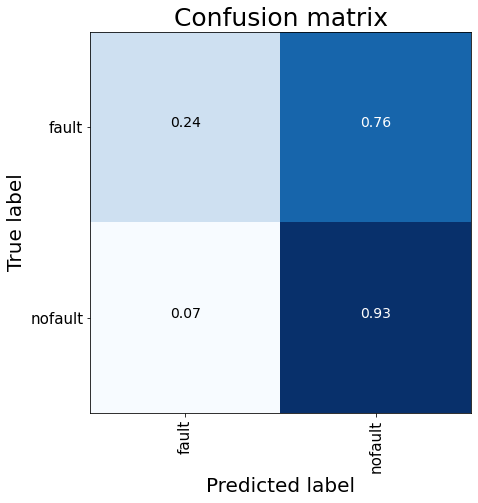

In [19]:
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(real), title="Confusion matrix")
plt.show()

In [20]:
# dummy classifier accuracy

sum(np.asarray(real) == 'nofault') / (sum(np.asarray(real) == 'fault') + sum(np.asarray(real) == 'nofault'))

0.6184668989547039